In [2]:
import sys
sys.path.append("/opt/CRPropa3/lib/python3.8/site-packages")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import crpropa
from tqdm import tqdm
from fancy import Data, Analysis, Model

In [4]:
# import uhecr data from uhecr file

uhecr_file = "../../data/UHECRdata.h5"
detector_type = "TA2015"

"""set detector and detector properties"""
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, Eth
else:
    raise Exception("Undefined detector type!")


# construct Dataset
data = Data()
data.add_uhecr(uhecr_file, detector_type)
data.add_detector(detector_properties)

# get uhecr detected arrival direction and detected energy
uhecr_coord = data.uhecr.coord
uhecr_energy = data.uhecr.energy

# get lon and lat arrays for future reference
# shift lons by 180. due to how its defined in mpl
uhecr_lons = np.pi - uhecr_coord.galactic.l.rad
uhecr_lats = uhecr_coord.galactic.b.rad

# number of uhecrs
N_uhecr = len(uhecr_coord)

# also get reconstruction uncertainties
arr_dir_unc = np.deg2rad(data.detector.coord_uncertainty)


In [5]:
data.detector.coord_uncertainty

1.7

In [6]:
# convert SkyCoord -> crpropa.Vector3d() to use with CRPropa
# coord is in galactic frame, lon and lat
# Angle definitions:
# CRPropa uses
#   longitude (phi) [-pi, pi] with 0 pointing in x-direction
#   colatitude (theta) [0, pi] with 0 pointing in z-direction
# matplotlib expects
#   longitude [-pi, pi] with 0 = 0 degrees
#   latitude [pi/2, -pi/2] with pi/2 = 90 degrees (north)
# SkyCoord uses:
#   lon: [0, 2pi]
#   lat: [-pi/2, pi/2]
uhecr_vector3d = []
for i, coord in enumerate(uhecr_coord):
    v = crpropa.Vector3d() 
    v.setRThetaPhi(1, np.pi / 2. - coord.galactic.b.rad, np.pi - coord.galactic.l.rad)
    uhecr_vector3d.append(v)

In [7]:
# set up CRPropa simulation and initialize objects
sim = crpropa.ModuleList()

# setup magnetic field
# gmf = crpropa.TF17Field()
gmf = crpropa.JF12Field()
seed = 691342
gmf.randomStriated(seed)
gmf.randomTurbulent(seed)

# Propagation model, parameters: (B-field model, target error, min step, max step)
sim.add(crpropa.PropagationCK(gmf, 1e-4, 0.1 * crpropa.parsec, 100 * crpropa.parsec))
obs = crpropa.Observer()

# observer at galactic boundary (20 kpc)
obs.add(crpropa.ObserverSurface( crpropa.Sphere(crpropa.Vector3d(0), 20 * crpropa.kpc) ))
# obs.onDetection(TextOutput('galactic_backtracking.txt', Output.Event3D))
sim.add(obs)
print(sim)


# composition, assume proton for now
# - nucleusId(A, Z)
pid = - crpropa.nucleusId(1,1)
# pid = - crpropa.nucleusId(14,7)
# pid = - crpropa.nucleusId(28, 14)

# CRPropa random number generator
crpropa_randgen = crpropa.Random() 

# position of earth in galactic coordinates
pos_earth = crpropa.Vector3d(-8.5, 0, 0) * crpropa.kpc

ModuleList
  Propagation in magnetic fields using the Cash-Karp method. Target error: 0.0001, Minimum Step: 0.0001 kpc, Maximum Step: 0.1 kpc
  Observer
    ObserverSurface: << Sphere: 
   Center: 0 0 0
   Radius: 6.17136e+20

    Flag: '' -> ''
    MakeInactive: yes




In [8]:
data.detector.energy_uncertainty

0.2

In [9]:
# obtain random directions based on reconstruction uncertainty

Nrand = 100

rand_arrdirs = np.zeros((N_uhecr, Nrand, 2))
defl_lons = np.zeros((N_uhecr, Nrand))
defl_lats = np.zeros((N_uhecr, Nrand))

# cos(theta), dot product
cos_thetas = np.zeros((N_uhecr, Nrand))

for i, arr_dir in tqdm(enumerate(uhecr_vector3d)):
    # seed = np.random.randint(10000000)
    # gmf.randomStriated(seed)
    # gmf.randomTurbulent(seed)
    energy = uhecr_energy[i] * crpropa.EeV
    for j in range(Nrand):
        rand_arrdir = crpropa_randgen.randVectorAroundMean(arr_dir, arr_dir_unc)

        c = crpropa.Candidate(crpropa.ParticleState(pid, energy, pos_earth, rand_arrdir))
        sim.run(c)

        defl_dir = c.current.getDirection()

        # append longitudes and latitudes
        # need to append np.pi / 2 - theta for latitude
        # also append the randomized arrival direction in lons and lats
        rand_arrdirs[i, j, :] = rand_arrdir.getPhi(), np.pi / 2. - rand_arrdir.getTheta()
        defl_lons[i, j] = defl_dir.getPhi()
        defl_lats[i, j] = np.pi / 2. - defl_dir.getTheta()

        # evaluate dot product between arrival direction (randomized) and deflected vector
        # dot exists with Vector3d() objects
        cos_theta = rand_arrdir.dot(defl_dir)
        cos_thetas[i, j] = cos_theta




0it [00:00, ?it/s]

Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267

2it [00:00,  6.22it/s]

Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.98372, -0.1777, 0.0267858) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(0.94715, 0.0221293, -0.320028) 0.029670597283903602
Vector(

4it [00:00,  8.36it/s]

Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.539914, -0.0581533) 0.029670597283903602
Vector(-0.839709, 0.5399

6it [00:00,  9.54it/s]

Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.029670597283903602
Vector(0.444297, -0.488478, 0.750992) 0.0296705972839036

8it [00:00, 10.55it/s]

Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.029670597283903602
Vector(0.205583, 0.920496, -0.332299) 0.0296705972839036

10it [00:01, 10.60it/s]

Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.508204, -0.23723, 0.827919) 0.029670597283903602
Vector(0.50820

12it [00:01, 10.24it/s]

Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.029670597283903602
Vector(0.691655, -0.223863, 0.686658) 0.0296705972839036

15it [00:01,  9.80it/s]

Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995878, 0.0895603) 0.029670597283903602
Vector(-0.0143371, 0.995

17it [00:01,  9.36it/s]

Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.820774, 0.427266, 0.379175) 0.029670597283903602
Vector(0.82077

18it [00:01,  8.30it/s]

Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.029670597283903602
Vector(0.911269, 0.394116, -0.119419) 0.0296705972839036

20it [00:02,  9.89it/s]

Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0.029670597283903602
Vector(-0.196878, 0.0962074, 0.975696) 0

22it [00:02, 10.32it/s]

Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0.029670597283903602
Vector(-0.150346, 0.985522, 0.0783796) 0

24it [00:02,  9.67it/s]

Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.764366, 0.631075, 0.132245) 0.029670597283903602
Vector(0.76436

26it [00:02,  8.67it/s]

Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.029670597283903602
Vector(0.967787, 0.237914, 0.0823762) 0.0296705972839036

27it [00:02,  8.66it/s]

Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.029670597283903602
Vector(0.800312, 0.0556852, 0.596992) 0.0296705972839036

29it [00:03,  8.63it/s]

Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.839758, 0.493289, 0.226873) 0.029670597283903602
Vector(0.83975

30it [00:03,  8.80it/s]

Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.640094, 0.703582, -0.30863) 0.029670597283903602
Vector(0.64009

33it [00:03,  9.22it/s]

Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0.029670597283903602
Vector(0.665238, -0.0143054, 0.746494) 0

34it [00:03,  9.31it/s]

Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0.029670597283903602
Vector(0.73553, -0.00291541, 0.677486) 0

37it [00:03,  9.71it/s]

Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.029670597283903602
Vector(0.795759, -0.210408, 0.567887) 0.0296705972839036

39it [00:04, 10.53it/s]

Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0.029670597283903602
Vector(-0.228608, 0.0128231, 0.973434) 0

41it [00:04, 10.70it/s]

Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.581902, -0.0816746) 0.029670597283903602
Vector(-0.809147, 0.5819

43it [00:04,  9.93it/s]

Vector(0.875525, 0.430196, 0.219972) 0.029670597283903602
Vector(0.875525, 0.430196, 0.219972) 0.029670597283903602
Vector(0.875525, 0.430196, 0.219972) 0.029670597283903602
Vector(0.875525, 0.430196, 0.219972) 0.029670597283903602
Vector(0.875525, 0.430196, 0.219972) 0.029670597283903602
Vector(0.875525, 0.430196, 0.219972) 0.029670597283903602
Vector(0.875525, 0.430196, 0.219972) 0.029670597283903602
Vector(0.875525, 0.430196, 0.219972) 0.029670597283903602
Vector(0.875525, 0.430196, 0.219972) 0.029670597283903602
Vector(0.607434, 0.676434, 0.416487) 0.029670597283903602
Vector(0.607434, 0.676434, 0.416487) 0.029670597283903602
Vector(0.607434, 0.676434, 0.416487) 0.029670597283903602
Vector(0.607434, 0.676434, 0.416487) 0.029670597283903602
Vector(0.607434, 0.676434, 0.416487) 0.029670597283903602
Vector(0.607434, 0.676434, 0.416487) 0.029670597283903602
Vector(0.607434, 0.676434, 0.416487) 0.029670597283903602
Vector(0.607434, 0.676434, 0.416487) 0.029670597283903602
Vector(0.60743

46it [00:04, 10.42it/s]

Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.029670597283903602
Vector(0.730356, -0.644024, 0.227625) 0.0296705972839036

48it [00:05, 10.48it/s]

Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399288) 0.029670597283903602
Vector(0.77086, 0.49633, -0.399

50it [00:05, 10.58it/s]

Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.474042, 0.328606, 0.816886) 0.029670597283903602
Vector(0.47404

52it [00:05, 10.55it/s]

Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.756157, 0.121072, 0.643092) 0.029670597283903602
Vector(0.75615

54it [00:05, 10.53it/s]

Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.029670597283903602
Vector(0.693236, 0.691915, -0.201689) 0.0296705972839036

56it [00:05, 10.63it/s]


Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 0.029670597283903602
Vector(0.531641, -0.0219885, 0.846685) 

58it [00:05, 11.33it/s]

Vector(-0.367884, 0.843401, -0.391581) 0.029670597283903602
Vector(-0.367884, 0.843401, -0.391581) 0.029670597283903602
Vector(-0.367884, 0.843401, -0.391581) 0.029670597283903602
Vector(-0.367884, 0.843401, -0.391581) 0.029670597283903602
Vector(-0.367884, 0.843401, -0.391581) 0.029670597283903602
Vector(-0.367884, 0.843401, -0.391581) 0.029670597283903602
Vector(-0.367884, 0.843401, -0.391581) 0.029670597283903602
Vector(-0.367884, 0.843401, -0.391581) 0.029670597283903602
Vector(-0.411855, 0.295786, 0.861909) 0.029670597283903602
Vector(-0.411855, 0.295786, 0.861909) 0.029670597283903602
Vector(-0.411855, 0.295786, 0.861909) 0.029670597283903602
Vector(-0.411855, 0.295786, 0.861909) 0.029670597283903602
Vector(-0.411855, 0.295786, 0.861909) 0.029670597283903602
Vector(-0.411855, 0.295786, 0.861909) 0.029670597283903602
Vector(-0.411855, 0.295786, 0.861909) 0.029670597283903602
Vector(-0.411855, 0.295786, 0.861909) 0.029670597283903602
Vector(-0.411855, 0.295786, 0.861909) 0.02967059

60it [00:06, 10.92it/s]

Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.029670597283903602
Vector(-0.168661, 0.389048, 0.905646) 0.0296705972839036

62it [00:06, 10.85it/s]

Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.146078, 0.522161, 0.840244) 0.029670597283903602
Vector(0.14607

64it [00:06,  9.91it/s]

Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.029670597283903602
Vector(0.432543, 0.900736, 0.0397588) 0.0296705972839036

66it [00:06, 10.04it/s]

Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572822, -0.764996) 0.029670597283903602
Vector(0.641483, -0.0572

68it [00:06,  9.39it/s]

Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.029670597283903602
Vector(0.943658, 0.306868, -0.123862) 0.0296705972839036

69it [00:07,  9.47it/s]

Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.029670597283903602
Vector(0.675583, 0.295986, -0.675263) 0.0296705972839036

72it [00:07,  9.73it/s]

Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.486227, 0.230472, 0.842892) 0.029670597283903602
Vector(0.48622

In [27]:
vec  = c.current.getPosition()

In [39]:
energy

10.97490893595

In [38]:
rand_arrdir = crpropa_randgen.randVectorAroundMean(arr_dir, arr_dir_unc)

c = crpropa.Candidate(crpropa.ParticleState(pid, energy, pos_earth, rand_arrdir))
sim.run(c)
(c.getTrajectoryLength() - c.current.getPosition().getDistanceTo(pos_earth))/crpropa.c_light/crpropa.hour/(60*60*24*365)

0.016467609017186677

In [17]:
vec.getDistanceTo(pos_earth)/crpropa.kpc

33.013235679254

In [ ]:
crpropa_randgen.randFisherVector1

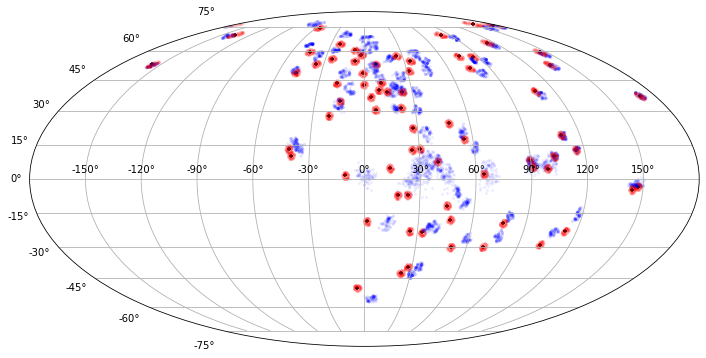

In [12]:
%matplotlib inline
# check with basic mpl mollweide projection
plt.figure(figsize=(12,7))
ax = plt.subplot(111, projection = 'mollweide')

ax.scatter(uhecr_lons, uhecr_lats, color="k", marker="+", s=10.0, alpha=1., label="True")
for i in range(N_uhecr):
    ax.scatter(defl_lons[i, :], defl_lats[i, :], color="b", alpha=0.05, s=4.0)
    ax.scatter(rand_arrdirs[i, :, 0], rand_arrdirs[i, :, 1], color="r", alpha=0.05, s=4.0)
# ax.scatter(defl_lons[1, :], defl_lats[1, :])
ax.grid()

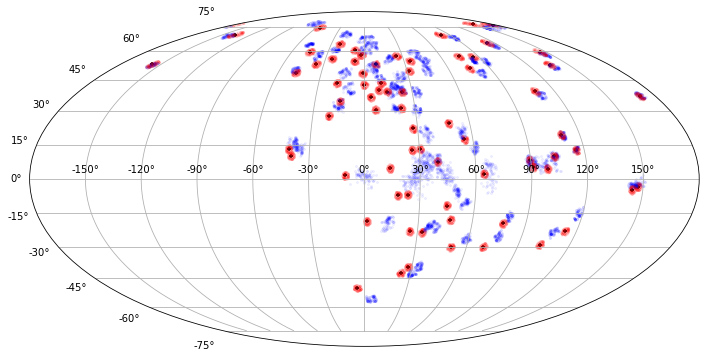

In [9]:
%matplotlib inline
# check with basic mpl mollweide projection
plt.figure(figsize=(12,7))
ax = plt.subplot(111, projection = 'mollweide')

ax.scatter(uhecr_lons, uhecr_lats, color="k", marker="+", s=10.0, alpha=1., label="True")
for i in range(N_uhecr):
    ax.scatter(defl_lons[i, :], defl_lats[i, :], color="b", alpha=0.05, s=4.0)
    ax.scatter(rand_arrdirs[i, :, 0], rand_arrdirs[i, :, 1], color="r", alpha=0.05, s=4.0)
# ax.scatter(defl_lons[1, :], defl_lats[1, :])
ax.grid()

In [10]:
'''Distributions of interest'''

def fischer(kappa, cos_thetaP):
    '''vMF distribution'''
    return (kappa * np.exp(kappa * cos_thetaP)) / (4.*np.pi * np.sinh(kappa))

def fischer_int(kappa, cos_thetaP):
    '''Integral of vMF function over all angles'''
    return (1. - np.exp(-kappa * (1 - cos_thetaP))) / (1. - np.exp(-2.*kappa))

def fischer_int_eq_P(kappa, cos_thetaP, P):
    '''Equation to find roots for'''
    return fischer_int(kappa, cos_thetaP) - P

def log_fischer(kappa, cos_thetaP):
    '''vMF distribution in log scale (base e)'''
    return np.log(kappa) - np.log(2*np.pi) - kappa * (1 - cos_thetaP)


In [11]:
# evaluate kappa_d from scalar product
# how this works is shown in solve_kappad.ipynb
from scipy.optimize import root
import h5py

kappa_ds = np.zeros((N_uhecr, Nrand))

P = 0.683  # as defined in Soiaporn paper

for (i, j), cos_theta in np.ndenumerate(cos_thetas):
    sol = root(fischer_int_eq_P, x0=1, args=(cos_theta, P))
    # print(sol)   # check solution

    kappa_sol = sol.x[0]
    kappa_ds[i, j] = kappa_sol

    # print("kappa = ", kappa_sol)

# evaluate mean kappa for each uhecr
kappa_d_mean = np.mean(kappa_ds, axis=1)

# store into h5py file with uhecr data
# since this only changes with different uhecr
# with h5py.File(uhecr_file, "r+") as f:
#     uhecr_group = f[detector_type]
#     uhecr_group["kappa_d"][()] = kappa_d_mean
    # uhecr_group.create_dataset("kappa_d", data=kappa_d_mean)

In [12]:
# check if we have written kappa_d correctly
with h5py.File(uhecr_file, "r") as f:
    print(f[detector_type]["kappa_gmf"]['JF12']['C']['kappa_gmf_rand'][...])

[[  1.27280959   3.0488716    1.62583004 ...   1.53531109   1.38309494
    3.02965423]
 [  2.23309967   3.30500296   2.61139899 ...   2.68232509   3.33551621
    2.54169826]
 [ 96.96845826  20.82696885  64.35395453 ...  60.13490379 105.36157933
  134.17460428]
 ...
 [ 10.36521456  11.48641706   9.23183696 ...  14.84995239   9.46307104
   12.59798543]
 [  4.51922679   5.26995209   4.83809879 ...   4.82413177   4.68753972
    4.09038334]
 [  3.61095822   3.67567635   3.19908662 ...   2.64580123   4.97158364
    3.2966153 ]]
